### Import libraries

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install matplotlib tqdm

In [3]:
%pip install h5py

In [4]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt

### Load data for machine learning

In [6]:
# Path to your HDF5 file
hdf5_file = "/content/drive/MyDrive/SATELLITE_DATASET/train_data.h5"

# Open the HDF5 file
with h5py.File(hdf5_file, 'r') as hdf:
    # Extract the images (X)
    X = np.array(hdf['images'])

    # Extract the labels (y)
    y = np.array(hdf['labels'])

# Check the shapes to ensure they are correct
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)

hdf5_file_test = "/content/drive/MyDrive/SATELLITE_DATASET/test_data.h5"
# Open the HDF5 file
with h5py.File(hdf5_file_test, 'r') as hdf:
    # Extract the images (X)
    X_test = np.array(hdf['images'])

# Check the shapes to ensure they are correct
print("Shape of X_test (images):", X_test.shape)

Shape of X (images): (1100000, 16, 16, 6)
Shape of y (labels): (1100000,)
Shape of X_test (images): (120000, 16, 16, 6)


### Train Test Split

In [8]:
print("\n" + "="*60)
print("METHOD 2: BALANCED TRAINING SET")
print("="*60)

# Get indices for each class
settlement_indices = np.where(y == 1)[0]
no_settlement_indices = np.where(y == 0)[0]

# For balanced training: use all settlement samples + equal number of no-settlement samples
n_settlement = len(settlement_indices)
balanced_no_settlement_indices = np.random.choice(
    no_settlement_indices,
    size=n_settlement,
    replace=False
)

# Create balanced training indices
balanced_train_indices = np.concatenate([settlement_indices, balanced_no_settlement_indices])
np.random.shuffle(balanced_train_indices)

# Remaining no-settlement samples for val/test
remaining_no_settlement = np.setdiff1d(no_settlement_indices, balanced_no_settlement_indices)

# Split remaining data for validation and test (maintain some imbalance but less severe)
val_settlement = int(0.1 * n_settlement)  # 10% of settlement data for validation
test_settlement = int(0.1 * n_settlement)  # 10% of settlement data for test

val_no_settlement = int(0.05 * len(remaining_no_settlement))  # 5% of remaining no-settlement for val
test_no_settlement = int(0.05 * len(remaining_no_settlement))  # 5% of remaining no-settlement for test

# Create validation indices
val_settlement_indices = np.random.choice(settlement_indices, size=val_settlement, replace=False)
val_no_settlement_indices = np.random.choice(remaining_no_settlement, size=val_no_settlement, replace=False)
val_indices = np.concatenate([val_settlement_indices, val_no_settlement_indices])

# Create test indices
available_settlement = np.setdiff1d(settlement_indices, val_settlement_indices)
available_no_settlement = np.setdiff1d(remaining_no_settlement, val_no_settlement_indices)

test_settlement_indices = np.random.choice(available_settlement, size=test_settlement, replace=False)
test_no_settlement_indices = np.random.choice(available_no_settlement, size=test_no_settlement, replace=False)
test_indices = np.concatenate([test_settlement_indices, test_no_settlement_indices])

# Extract balanced datasets
X_train_balanced = X[balanced_train_indices]
y_train_balanced = y[balanced_train_indices]

X_val_balanced = X[val_indices]
y_val_balanced = y[val_indices]

X_test_balanced = X[test_indices]
y_test_balanced = y[test_indices]

print(f"\nBalanced Train set: {X_train_balanced.shape[0]} samples")
print(f"  - Settlement: {np.sum(y_train_balanced == 1)} ({np.sum(y_train_balanced == 1)/len(y_train_balanced)*100:.1f}%)")
print(f"  - No settlement: {np.sum(y_train_balanced == 0)} ({np.sum(y_train_balanced == 0)/len(y_train_balanced)*100:.1f}%)")

print(f"\nValidation set: {X_val_balanced.shape[0]} samples")
print(f"  - Settlement: {np.sum(y_val_balanced == 1)} ({np.sum(y_val_balanced == 1)/len(y_val_balanced)*100:.1f}%)")
print(f"  - No settlement: {np.sum(y_val_balanced == 0)} ({np.sum(y_val_balanced == 0)/len(y_val_balanced)*100:.1f}%)")

print(f"\nTest set: {X_test_balanced.shape[0]} samples")
print(f"  - Settlement: {np.sum(y_test_balanced == 1)} ({np.sum(y_test_balanced == 1)/len(y_test_balanced)*100:.1f}%)")
print(f"  - No settlement: {np.sum(y_test_balanced == 0)} ({np.sum(y_test_balanced == 0)/len(y_test_balanced)*100:.1f}%)")


METHOD 2: BALANCED TRAINING SET

Balanced Train set: 200000 samples
  - Settlement: 100000 (50.0%)
  - No settlement: 100000 (50.0%)

Validation set: 55000 samples
  - Settlement: 10000 (18.2%)
  - No settlement: 45000 (81.8%)

Test set: 55000 samples
  - Settlement: 10000 (18.2%)
  - No settlement: 45000 (81.8%)


#### RFC

In [9]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
from collections import Counter

# Assuming you already have the balanced splits:
# X_train_balanced, y_train_balanced, X_val_balanced, y_val_balanced, X_test_balanced, y_test_balanced

print("Using pre-created balanced datasets...")
print(f"Train set: {X_train_balanced.shape[0]} samples")
print(f"Validation set: {X_val_balanced.shape[0]} samples")
print(f"Test set: {X_test_balanced.shape[0]} samples")

# Reshape data for Random Forest (flatten the image data)
# From (samples, 16, 16, 6) to (samples, 16*16*6)
print("\nReshaping data for Random Forest...")
X_train = X_train_balanced.reshape(X_train_balanced.shape[0], -1)
X_val = X_val_balanced.reshape(X_val_balanced.shape[0], -1)
X_test = X_test_balanced.reshape(X_test_balanced.shape[0], -1)

y_train = y_train_balanced
y_val = y_val_balanced
y_test = y_test_balanced

print(f"Flattened data shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")

# Print class distribution for each split
for split_name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    pos_count = np.sum(y_split == 1)
    neg_count = np.sum(y_split == 0)
    pos_pct = pos_count / len(y_split) * 100
    print(f"{split_name}: Settlement={pos_count} ({pos_pct:.1f}%), No Settlement={neg_count} ({100-pos_pct:.1f}%)")

# Initialize Random Forest (no class_weight needed since training is balanced)
print("\nInitializing Random Forest Classifier...")
rf_classifier = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=20,               # Maximum depth of trees
    min_samples_split=5,        # Minimum samples to split a node
    min_samples_leaf=2,         # Minimum samples in a leaf
    class_weight=None,          # No class weighting needed with balanced training
    random_state=42,
    n_jobs=-1,                  # Use all available cores
    verbose=1                   # Show progress
)

# Train the model
print("Training Random Forest...")
start_time = time.time()
rf_classifier.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions on all splits
print("\nMaking predictions...")
y_train_pred = rf_classifier.predict(X_train)
y_val_pred = rf_classifier.predict(X_val)
y_test_pred = rf_classifier.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n" + "="*50)
print("ACCURACY RESULTS")
print("="*50)
print(f"Training Accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Create prediction vs actual table for test set
print("\n" + "="*50)
print("PREDICTION vs ACTUAL TABLE (Test Set)")
print("="*50)

# Create a comprehensive comparison table
test_results_df = pd.DataFrame({
    'Sample_Index': range(len(y_test)),
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Correct': y_test == y_test_pred
})

# Add categorical labels for better readability
test_results_df['Actual_Label'] = test_results_df['Actual'].map({0: 'No Settlement', 1: 'Settlement'})
test_results_df['Predicted_Label'] = test_results_df['Predicted'].map({0: 'No Settlement', 1: 'Settlement'})

# Show first 20 predictions
print("First 20 predictions:")
print(test_results_df[['Actual_Label', 'Predicted_Label', 'Correct']].head(20))

# Summary statistics for test predictions
print(f"\nTest Set Summary:")
print(f"Total samples: {len(y_test)}")
print(f"Correct predictions: {np.sum(test_results_df['Correct'])}")
print(f"Incorrect predictions: {np.sum(~test_results_df['Correct'])}")

# Confusion Matrix for test set
print("\n" + "="*50)
print("CONFUSION MATRIX (Test Set)")
print("="*50)
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print("                 Predicted")
print("Actual    No Settlement  Settlement")
print(f"No Settlement    {cm[0,0]:8d}    {cm[0,1]:8d}")
print(f"Settlement       {cm[1,0]:8d}    {cm[1,1]:8d}")

# Calculate detailed metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Metrics:")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")

# Calculate precision, recall, F1-score
if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = 0

if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print(f"\nClassification Metrics for Settlement Detection:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1_score:.4f}")

# Detailed classification report
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT (Test Set)")
print("="*50)
print(classification_report(y_test, y_test_pred,
                          target_names=['No Settlement', 'Settlement']))

# Feature importance (top features)
print("\n" + "="*50)
print("TOP 10 FEATURE IMPORTANCES")
print("="*50)
feature_importance = rf_classifier.feature_importances_
top_features_idx = np.argsort(feature_importance)[-10:][::-1]

print("Rank  Feature_Index  Importance")
print("-" * 30)
for i, idx in enumerate(top_features_idx):
    print(f"{i+1:3d}   {idx:10d}   {feature_importance[idx]:.6f}")

# Analysis by class
print("\n" + "="*50)
print("ANALYSIS BY ACTUAL CLASS (Test Set)")
print("="*50)

for class_val, class_name in [(0, 'No Settlement'), (1, 'Settlement')]:
    mask = y_test == class_val
    class_actual = y_test[mask]
    class_pred = y_test_pred[mask]
    class_accuracy = accuracy_score(class_actual, class_pred)

    print(f"\n{class_name} (Class {class_val}):")
    print(f"  Total samples: {np.sum(mask)}")
    print(f"  Correctly predicted: {np.sum(class_actual == class_pred)}")
    print(f"  Class accuracy: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

# Save results
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Save the prediction table
test_results_df.to_csv('/content/drive/MyDrive/SATELLITE_DATASET/test_predictions_balanced.csv', index=False)
print("✓ Test predictions saved to 'test_predictions_balanced.csv'")

# Save accuracies
accuracy_results = {
    'train_accuracy': train_accuracy,
    'validation_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'training_time_seconds': training_time
}

np.save('/content/drive/MyDrive/SATELLITE_DATASET/accuracy_results_balanced.npy', accuracy_results)
print("✓ Accuracy results saved to 'accuracy_results_balanced.npy'")

# Save confusion matrix
np.save('/content/drive/MyDrive/SATELLITE_DATASET/confusion_matrix_balanced.npy', cm)
print("✓ Confusion matrix saved to 'confusion_matrix_balanced.npy'")

# Display complete prediction table
print("\n" + "="*50)
print("COMPLETE PREDICTION TABLE")
print("="*50)
print("Displaying all test predictions...")
print(test_results_df.to_string(index=False))

print(f"\n✓ All results saved successfully!")
print(f"Load prediction table with: pd.read_csv('test_predictions_balanced.csv')")
print(f"Load accuracies with: np.load('accuracy_results_balanced.npy', allow_pickle=True).item()")

# Summary
print("\n" + "="*60)
print("FINAL SUMMARY - BALANCED TRAINING APPROACH")
print("="*60)
print(f"Model: Random Forest with {rf_classifier.n_estimators} trees")
print(f"Training approach: BALANCED (50:50 class ratio)")
print(f"Training samples: {len(y_train):,} (Settlement: {np.sum(y_train==1)}, No Settlement: {np.sum(y_train==0)})")
print(f"Training time: {training_time:.2f} seconds")
print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Settlement detection F1-score: {f1_score:.4f}")
print("="*60)

Using pre-created balanced datasets...
Train set: 200000 samples
Validation set: 55000 samples
Test set: 55000 samples

Reshaping data for Random Forest...
Flattened data shapes:
  X_train: (200000, 1536)
  X_val: (55000, 1536)
  X_test: (55000, 1536)
Train: Settlement=100000 (50.0%), No Settlement=100000 (50.0%)
Validation: Settlement=10000 (18.2%), No Settlement=45000 (81.8%)
Test: Settlement=10000 (18.2%), No Settlement=45000 (81.8%)

Initializing Random Forest Classifier...
Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.8min finished


Training completed in 1008.09 seconds

Making predictions...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    9.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.0s finished


Streaming output truncated to the last 5000 lines.
        50015       0          0     True No Settlement   No Settlement
        50016       0          0     True No Settlement   No Settlement
        50017       0          0     True No Settlement   No Settlement
        50018       0          0     True No Settlement   No Settlement
        50019       0          0     True No Settlement   No Settlement
        50020       0          1    False No Settlement      Settlement
        50021       0          1    False No Settlement      Settlement
        50022       0          0     True No Settlement   No Settlement
        50023       0          1    False No Settlement      Settlement
        50024       0          0     True No Settlement   No Settlement
        50025       0          1    False No Settlement      Settlement
        50026       0          1    False No Settlement      Settlement
        50027       0          0     True No Settlement   No Settlement
        50028

#### MLP

In [10]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
from collections import Counter

# Assuming you already have the balanced splits:
# X_train_balanced, y_train_balanced, X_val_balanced, y_val_balanced, X_test_balanced, y_test_balanced

print("Using pre-created balanced datasets for MLP...")
print(f"Train set: {X_train_balanced.shape[0]} samples")
print(f"Validation set: {X_val_balanced.shape[0]} samples")
print(f"Test set: {X_test_balanced.shape[0]} samples")

# Reshape data for MLP (flatten the image data)
# From (samples, 16, 16, 6) to (samples, 16*16*6)
print("\nReshaping data for MLP...")
X_train = X_train_balanced.reshape(X_train_balanced.shape[0], -1)
X_val = X_val_balanced.reshape(X_val_balanced.shape[0], -1)
X_test = X_test_balanced.reshape(X_test_balanced.shape[0], -1)

y_train = y_train_balanced
y_val = y_val_balanced
y_test = y_test_balanced

print(f"Flattened data shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")

# Feature scaling (crucial for neural networks)
print("\nApplying feature scaling...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")

# Print class distribution for each split
for split_name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    pos_count = np.sum(y_split == 1)
    neg_count = np.sum(y_split == 0)
    pos_pct = pos_count / len(y_split) * 100
    print(f"{split_name}: Settlement={pos_count} ({pos_pct:.1f}%), No Settlement={neg_count} ({100-pos_pct:.1f}%)")

# Initialize MLP Classifier
print("\nInitializing MLP Classifier...")
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),  # Three hidden layers
    activation='relu',                    # ReLU activation
    solver='adam',                       # Adam optimizer
    alpha=0.001,                        # L2 regularization
    batch_size='auto',                  # Automatic batch size
    learning_rate='constant',           # Constant learning rate
    learning_rate_init=0.001,          # Initial learning rate
    max_iter=500,                      # Maximum iterations
    shuffle=True,                      # Shuffle data each iteration
    random_state=42,                   # For reproducibility
    early_stopping=True,               # Stop early if no improvement
    validation_fraction=0.1,           # Fraction for early stopping validation
    n_iter_no_change=20,              # Patience for early stopping
    verbose=True                       # Show progress
)

# Train the model
print("Training MLP...")
start_time = time.time()
mlp_classifier.fit(X_train_scaled, y_train)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")
print(f"Training stopped at iteration: {mlp_classifier.n_iter_}")

# Make predictions on all splits
print("\nMaking predictions...")
y_train_pred = mlp_classifier.predict(X_train_scaled)
y_val_pred = mlp_classifier.predict(X_val_scaled)
y_test_pred = mlp_classifier.predict(X_test_scaled)

# Get prediction probabilities for test set (useful for threshold tuning)
y_test_proba = mlp_classifier.predict_proba(X_test_scaled)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n" + "="*50)
print("ACCURACY RESULTS")
print("="*50)
print(f"Training Accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Training history information
print(f"\nTraining Information:")
print(f"Final loss: {mlp_classifier.loss_:.6f}")
print(f"Number of layers: {mlp_classifier.n_layers_}")
print(f"Number of outputs: {mlp_classifier.n_outputs_}")

# Create prediction vs actual table for test set
print("\n" + "="*50)
print("PREDICTION vs ACTUAL TABLE (Test Set)")
print("="*50)

# Create a comprehensive comparison table with probabilities
test_results_df = pd.DataFrame({
    'Sample_Index': range(len(y_test)),
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Prob_No_Settlement': y_test_proba[:, 0],
    'Prob_Settlement': y_test_proba[:, 1],
    'Correct': y_test == y_test_pred
})

# Add categorical labels for better readability
test_results_df['Actual_Label'] = test_results_df['Actual'].map({0: 'No Settlement', 1: 'Settlement'})
test_results_df['Predicted_Label'] = test_results_df['Predicted'].map({0: 'No Settlement', 1: 'Settlement'})

# Show first 20 predictions
print("First 20 predictions:")
print(test_results_df[['Actual_Label', 'Predicted_Label', 'Prob_Settlement', 'Correct']].head(20))

# Summary statistics for test predictions
print(f"\nTest Set Summary:")
print(f"Total samples: {len(y_test)}")
print(f"Correct predictions: {np.sum(test_results_df['Correct'])}")
print(f"Incorrect predictions: {np.sum(~test_results_df['Correct'])}")

# Confusion Matrix for test set
print("\n" + "="*50)
print("CONFUSION MATRIX (Test Set)")
print("="*50)
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print("                 Predicted")
print("Actual    No Settlement  Settlement")
print(f"No Settlement    {cm[0,0]:8d}    {cm[0,1]:8d}")
print(f"Settlement       {cm[1,0]:8d}    {cm[1,1]:8d}")

# Calculate detailed metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Metrics:")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")

# Calculate precision, recall, F1-score
if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = 0

if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print(f"\nClassification Metrics for Settlement Detection:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1_score:.4f}")

# Detailed classification report
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT (Test Set)")
print("="*50)
print(classification_report(y_test, y_test_pred,
                          target_names=['No Settlement', 'Settlement']))

# Analysis by class
print("\n" + "="*50)
print("ANALYSIS BY ACTUAL CLASS (Test Set)")
print("="*50)

for class_val, class_name in [(0, 'No Settlement'), (1, 'Settlement')]:
    mask = y_test == class_val
    class_actual = y_test[mask]
    class_pred = y_test_pred[mask]
    class_proba = y_test_proba[mask, class_val]
    class_accuracy = accuracy_score(class_actual, class_pred)

    print(f"\n{class_name} (Class {class_val}):")
    print(f"  Total samples: {np.sum(mask)}")
    print(f"  Correctly predicted: {np.sum(class_actual == class_pred)}")
    print(f"  Class accuracy: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")
    print(f"  Average prediction confidence: {np.mean(class_proba):.4f}")

# Probability distribution analysis
print("\n" + "="*50)
print("PREDICTION PROBABILITY ANALYSIS")
print("="*50)

# Settlement predictions confidence
settlement_mask = y_test_pred == 1
if np.any(settlement_mask):
    settlement_proba = y_test_proba[settlement_mask, 1]
    print(f"Settlement Predictions (n={np.sum(settlement_mask)}):")
    print(f"  Average confidence: {np.mean(settlement_proba):.4f}")
    print(f"  Min confidence: {np.min(settlement_proba):.4f}")
    print(f"  Max confidence: {np.max(settlement_proba):.4f}")

# No settlement predictions confidence
no_settlement_mask = y_test_pred == 0
if np.any(no_settlement_mask):
    no_settlement_proba = y_test_proba[no_settlement_mask, 0]
    print(f"\nNo Settlement Predictions (n={np.sum(no_settlement_mask)}):")
    print(f"  Average confidence: {np.mean(no_settlement_proba):.4f}")
    print(f"  Min confidence: {np.min(no_settlement_proba):.4f}")
    print(f"  Max confidence: {np.max(no_settlement_proba):.4f}")

# Save results
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Save the prediction table
test_results_df.to_csv('/content/drive/MyDrive/SATELLITE_DATASET/test_predictions_mlp.csv', index=False)
print("✓ Test predictions saved to 'test_predictions_mlp.csv'")

# Save accuracies and model info
accuracy_results = {
    'train_accuracy': train_accuracy,
    'validation_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'training_time_seconds': training_time,
    'n_iterations': mlp_classifier.n_iter_,
    'final_loss': mlp_classifier.loss_,
    'hidden_layers': mlp_classifier.hidden_layer_sizes
}

np.save('/content/drive/MyDrive/SATELLITE_DATASET/accuracy_results_mlp.npy', accuracy_results)
print("✓ Accuracy results saved to 'accuracy_results_mlp.npy'")

# Save confusion matrix
np.save('/content/drive/MyDrive/SATELLITE_DATASET/confusion_matrix_mlp.npy', cm)
print("✓ Confusion matrix saved to 'confusion_matrix_mlp.npy'")

# Save the scaler for future use
import joblib
joblib.dump(scaler, '/content/drive/MyDrive/SATELLITE_DATASET/scaler_mlp.pkl')
print("✓ Feature scaler saved to 'scaler_mlp.pkl'")

# Display complete prediction table
print("\n" + "="*50)
print("COMPLETE PREDICTION TABLE")
print("="*50)
print("Displaying all test predictions...")
print(test_results_df.to_string(index=False))

print(f"\n✓ All results saved successfully!")
print(f"Load prediction table with: pd.read_csv('test_predictions_mlp.csv')")
print(f"Load accuracies with: np.load('accuracy_results_mlp.npy', allow_pickle=True).item()")
print(f"Load scaler with: joblib.load('scaler_mlp.pkl')")

# Summary
print("\n" + "="*60)
print("FINAL SUMMARY - MLP WITH BALANCED TRAINING")
print("="*60)
print(f"Model: Multilayer Perceptron")
print(f"Architecture: {mlp_classifier.hidden_layer_sizes} hidden layers")
print(f"Training approach: BALANCED (50:50 class ratio)")
print(f"Training samples: {len(y_train):,} (Settlement: {np.sum(y_train==1)}, No Settlement: {np.sum(y_train==0)})")
print(f"Training time: {training_time:.2f} seconds")
print(f"Training iterations: {mlp_classifier.n_iter_}")
print(f"Final loss: {mlp_classifier.loss_:.6f}")
print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Settlement detection F1-score: {f1_score:.4f}")
print("="*60)

Streaming output truncated to the last 5000 lines.
        50019       0          0        9.921055e-01     7.894539e-03     True No Settlement   No Settlement
        50020       0          0        9.758723e-01     2.412772e-02     True No Settlement   No Settlement
        50021       0          1        1.943150e-01     8.056850e-01    False No Settlement      Settlement
        50022       0          0        9.825871e-01     1.741285e-02     True No Settlement   No Settlement
        50023       0          0        6.683943e-01     3.316057e-01     True No Settlement   No Settlement
        50024       0          0        6.474045e-01     3.525955e-01     True No Settlement   No Settlement
        50025       0          1        5.429299e-04     9.994571e-01    False No Settlement      Settlement
        50026       0          0        6.811338e-01     3.188662e-01     True No Settlement   No Settlement
        50027       0          1        2.553142e-01     7.446858e-01    Fals

#### XGBoost Classifier

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
from collections import Counter

# Assuming you already have the balanced splits:
# X_train_balanced, y_train_balanced, X_val_balanced, y_val_balanced, X_test_balanced, y_test_balanced

print("Using pre-created balanced datasets...")
print(f"Train set: {X_train_balanced.shape[0]} samples")
print(f"Validation set: {X_val_balanced.shape[0]} samples")
print(f"Test set: {X_test_balanced.shape[0]} samples")

# Reshape data for XGBoost (flatten the image data)
# From (samples, 16, 16, 6) to (samples, 16*16*6)
print("\nReshaping data for XGBoost...")
X_train = X_train_balanced.reshape(X_train_balanced.shape[0], -1)
X_val = X_val_balanced.reshape(X_val_balanced.shape[0], -1)
X_test = X_test_balanced.reshape(X_test_balanced.shape[0], -1)

y_train = y_train_balanced
y_val = y_val_balanced
y_test = y_test_balanced

print(f"Flattened data shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  X_test: {X_test.shape}")

# Print class distribution for each split
for split_name, y_split in [("Train", y_train), ("Validation", y_val), ("Test", y_test)]:
    pos_count = np.sum(y_split == 1)
    neg_count = np.sum(y_split == 0)
    pos_pct = pos_count / len(y_split) * 100
    print(f"{split_name}: Settlement={pos_count} ({pos_pct:.1f}%), No Settlement={neg_count} ({100-pos_pct:.1f}%)")

# Create DMatrix objects for XGBoost (more efficient)
print("\nCreating DMatrix objects for XGBoost...")
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters
print("\nInitializing XGBoost Classifier...")
xgb_params = {
    'objective': 'binary:logistic',     # Binary classification
    'eval_metric': 'logloss',           # Evaluation metric
    'max_depth': 8,                     # Maximum depth of trees
    'learning_rate': 0.1,               # Learning rate (eta)
    'subsample': 0.8,                   # Subsample ratio of training instances
    'colsample_bytree': 0.8,            # Subsample ratio of features
    'min_child_weight': 1,              # Minimum sum of instance weight in a child
    'reg_alpha': 0.1,                   # L1 regularization
    'reg_lambda': 1.0,                  # L2 regularization
    'random_state': 42,
    'n_jobs': -1,                       # Use all available cores
    'verbosity': 1                      # Show progress
}

# Set up evaluation list for monitoring
evallist = [(dtrain, 'train'), (dval, 'val')]

# Train the model
print("Training XGBoost...")
start_time = time.time()

xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,                # Number of boosting rounds
    evals=evallist,                     # Evaluation datasets
    early_stopping_rounds=10,           # Stop if no improvement for 10 rounds
    verbose_eval=10                     # Print evaluation every 10 rounds
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions on all splits
print("\nMaking predictions...")
y_train_pred_prob = xgb_model.predict(dtrain)
y_val_pred_prob = xgb_model.predict(dval)
y_test_pred_prob = xgb_model.predict(dtest)

# Convert probabilities to binary predictions (threshold = 0.5)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n" + "="*50)
print("ACCURACY RESULTS")
print("="*50)
print(f"Training Accuracy:   {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"Test Accuracy:       {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Create prediction vs actual table for test set
print("\n" + "="*50)
print("PREDICTION vs ACTUAL TABLE (Test Set)")
print("="*50)

# Create a comprehensive comparison table
test_results_df = pd.DataFrame({
    'Sample_Index': range(len(y_test)),
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Prediction_Probability': y_test_pred_prob,
    'Correct': y_test == y_test_pred
})

# Add categorical labels for better readability
test_results_df['Actual_Label'] = test_results_df['Actual'].map({0: 'No Settlement', 1: 'Settlement'})
test_results_df['Predicted_Label'] = test_results_df['Predicted'].map({0: 'No Settlement', 1: 'Settlement'})

# Show first 20 predictions
print("First 20 predictions:")
print(test_results_df[['Actual_Label', 'Predicted_Label', 'Prediction_Probability', 'Correct']].head(20))

# Summary statistics for test predictions
print(f"\nTest Set Summary:")
print(f"Total samples: {len(y_test)}")
print(f"Correct predictions: {np.sum(test_results_df['Correct'])}")
print(f"Incorrect predictions: {np.sum(~test_results_df['Correct'])}")

# Confusion Matrix for test set
print("\n" + "="*50)
print("CONFUSION MATRIX (Test Set)")
print("="*50)
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print("                 Predicted")
print("Actual    No Settlement  Settlement")
print(f"No Settlement    {cm[0,0]:8d}    {cm[0,1]:8d}")
print(f"Settlement       {cm[1,0]:8d}    {cm[1,1]:8d}")

# Calculate detailed metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Metrics:")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")

# Calculate precision, recall, F1-score
if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = 0

if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print(f"\nClassification Metrics for Settlement Detection:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1_score:.4f}")

# Detailed classification report
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT (Test Set)")
print("="*50)
print(classification_report(y_test, y_test_pred,
                          target_names=['No Settlement', 'Settlement']))

# Feature importance (top features)
print("\n" + "="*50)
print("TOP 10 FEATURE IMPORTANCES")
print("="*50)

# Get feature importance from XGBoost model
feature_importance = xgb_model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'

# Convert to array format (XGBoost returns dict with feature names)
if feature_importance:
    # Convert feature importance dict to sorted list
    feature_names = [f'f{i}' for i in range(X_train.shape[1])]
    importance_array = np.zeros(X_train.shape[1])

    for feature_name, importance in feature_importance.items():
        feature_idx = int(feature_name[1:])  # Remove 'f' prefix
        importance_array[feature_idx] = importance

    top_features_idx = np.argsort(importance_array)[-10:][::-1]

    print("Rank  Feature_Index  Importance")
    print("-" * 30)
    for i, idx in enumerate(top_features_idx):
        print(f"{i+1:3d}   {idx:10d}   {importance_array[idx]:.6f}")
else:
    print("No feature importance available from this model.")

# Analysis by class
print("\n" + "="*50)
print("ANALYSIS BY ACTUAL CLASS (Test Set)")
print("="*50)

for class_val, class_name in [(0, 'No Settlement'), (1, 'Settlement')]:
    mask = y_test == class_val
    class_actual = y_test[mask]
    class_pred = y_test_pred[mask]
    class_accuracy = accuracy_score(class_actual, class_pred)

    print(f"\n{class_name} (Class {class_val}):")
    print(f"  Total samples: {np.sum(mask)}")
    print(f"  Correctly predicted: {np.sum(class_actual == class_pred)}")
    print(f"  Class accuracy: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

# Save results
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Save the prediction table
test_results_df.to_csv('/content/drive/MyDrive/SATELLITE_DATASET/test_predictions_xgboost_balanced.csv', index=False)
print("✓ Test predictions saved to 'test_predictions_xgboost_balanced.csv'")

# Save accuracies
accuracy_results = {
    'train_accuracy': train_accuracy,
    'validation_accuracy': val_accuracy,
    'test_accuracy': test_accuracy,
    'training_time_seconds': training_time,
    'best_iteration': xgb_model.best_iteration if hasattr(xgb_model, 'best_iteration') else None
}

np.save('/content/drive/MyDrive/SATELLITE_DATASET/accuracy_results_xgboost_balanced.npy', accuracy_results)
print("✓ Accuracy results saved to 'accuracy_results_xgboost_balanced.npy'")

# Save confusion matrix
np.save('/content/drive/MyDrive/SATELLITE_DATASET/confusion_matrix_xgboost_balanced.npy', cm)
print("✓ Confusion matrix saved to 'confusion_matrix_xgboost_balanced.npy'")

# Save the trained model
xgb_model.save_model('/content/drive/MyDrive/SATELLITE_DATASET/xgboost_settlement_model.json')
print("✓ XGBoost model saved to 'xgboost_settlement_model.json'")

# Display complete prediction table
print("\n" + "="*50)
print("COMPLETE PREDICTION TABLE")
print("="*50)
print("Displaying all test predictions...")
print(test_results_df.to_string(index=False))

print(f"\n✓ All results saved successfully!")
print(f"Load prediction table with: pd.read_csv('test_predictions_xgboost_balanced.csv')")
print(f"Load accuracies with: np.load('accuracy_results_xgboost_balanced.npy', allow_pickle=True).item()")
print(f"Load model with: xgb.Booster(); model.load_model('xgboost_settlement_model.json')")

# Summary
print("\n" + "="*60)
print("FINAL SUMMARY - BALANCED TRAINING APPROACH (XGBoost)")
print("="*60)
print(f"Model: XGBoost Classifier")
print(f"Training approach: BALANCED (50:50 class ratio)")
print(f"Training samples: {len(y_train):,} (Settlement: {np.sum(y_train==1)}, No Settlement: {np.sum(y_train==0)})")
print(f"Training time: {training_time:.2f} seconds")
print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Settlement detection F1-score: {f1_score:.4f}")
print(f"Best iteration: {xgb_model.best_iteration if hasattr(xgb_model, 'best_iteration') else 'N/A'}")
print("="*60)

# Additional XGBoost specific analysis
print("\n" + "="*50)
print("XGBOOST SPECIFIC ANALYSIS")
print("="*50)

# Plot feature importance (if matplotlib is available)
try:
    import matplotlib.pyplot as plt

    # Plot top 20 feature importances
    if feature_importance:
        top_20_idx = np.argsort(importance_array)[-20:]
        plt.figure(figsize=(10, 8))
        plt.barh(range(20), importance_array[top_20_idx])
        plt.yticks(range(20), [f'Feature {idx}' for idx in top_20_idx])
        plt.xlabel('Feature Importance (Weight)')
        plt.title('Top 20 XGBoost Feature Importances')
        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/SATELLITE_DATASET/xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✓ Feature importance plot saved to 'xgboost_feature_importance.png'")

except ImportError:
    print("Matplotlib not available - skipping feature importance plot")

# Print model parameters used
print(f"\nModel Parameters Used:")
for param, value in xgb_params.items():
    print(f"  {param}: {value}")

# Prediction confidence analysis
print("\n" + "="*50)
print("PREDICTION CONFIDENCE ANALYSIS")
print("="*50)

# Analyze prediction probabilities
prob_ranges = [(0.0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5),
               (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]

print("Test Set Prediction Probability Distribution:")
print("Probability Range    Count    Percentage")
print("-" * 40)

for low, high in prob_ranges:
    mask = (y_test_pred_prob >= low) & (y_test_pred_prob < high)
    if high == 1.0:  # Include 1.0 in the last range
        mask = (y_test_pred_prob >= low) & (y_test_pred_prob <= high)

    count = np.sum(mask)
    percentage = count / len(y_test_pred_prob) * 100
    print(f"[{low:.1f}, {high:.1f}{'.' if high < 1.0 else ']'})       {count:6d}    {percentage:6.2f}%")

# High confidence predictions analysis
high_conf_settlement = np.sum(y_test_pred_prob > 0.9)
high_conf_no_settlement = np.sum(y_test_pred_prob < 0.1)
uncertain_predictions = np.sum((y_test_pred_prob >= 0.4) & (y_test_pred_prob <= 0.6))

print(f"\nConfidence Analysis:")
print(f"High confidence Settlement (>0.9): {high_conf_settlement}")
print(f"High confidence No Settlement (<0.1): {high_conf_no_settlement}")
print(f"Uncertain predictions (0.4-0.6): {uncertain_predictions}")

print("\n" + "="*60)
print("XGBoost TRAINING COMPLETE!")
print("="*60)

Using pre-created balanced datasets...
Train set: 200000 samples
Validation set: 55000 samples
Test set: 55000 samples

Reshaping data for XGBoost...
Flattened data shapes:
  X_train: (200000, 1536)
  X_val: (55000, 1536)
  X_test: (55000, 1536)
Train: Settlement=100000 (50.0%), No Settlement=100000 (50.0%)
Validation: Settlement=10000 (18.2%), No Settlement=45000 (81.8%)
Test: Settlement=10000 (18.2%), No Settlement=45000 (81.8%)

Creating DMatrix objects for XGBoost...


### .

In [ ]:
# Path to your HDF5 file
hdf5_file = "train_data.h5"

# Open the HDF5 file
with h5py.File(hdf5_file, 'r') as hdf:
    # Extract the images (X)
    X = np.array(hdf['images'])

    # Extract the labels (y)
    y = np.array(hdf['labels'])

# Check the shapes to ensure they are correct
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)

hdf5_file_test = "test_data.h5"
# Open the HDF5 file
with h5py.File(hdf5_file_test, 'r') as hdf:
    # Extract the images (X)
    X_test = np.array(hdf['images'])

# Check the shapes to ensure they are correct
print("Shape of X_test (images):", X_test.shape)

Shape of X (images): (1100000, 16, 16, 6)
Shape of y (labels): (1100000,)
Shape of X_test (images): (120000, 16, 16, 6)


In [ ]:
i=0
while True:
    print(f"Label of {i} image: {y[i]}")
    if y[i] == 1:
        break
    i=i+1

Label of 0 image: 0
Label of 1 image: 0
Label of 2 image: 0
Label of 3 image: 0
Label of 4 image: 0
Label of 5 image: 0
Label of 6 image: 0
Label of 7 image: 0
Label of 8 image: 0
Label of 9 image: 0
Label of 10 image: 0
Label of 11 image: 0
Label of 12 image: 0
Label of 13 image: 0
Label of 14 image: 0
Label of 15 image: 0
Label of 16 image: 0
Label of 17 image: 0
Label of 18 image: 0
Label of 19 image: 0
Label of 20 image: 0
Label of 21 image: 0
Label of 22 image: 0
Label of 23 image: 0
Label of 24 image: 0
Label of 25 image: 0
Label of 26 image: 0
Label of 27 image: 0
Label of 28 image: 0
Label of 29 image: 0
Label of 30 image: 0
Label of 31 image: 0
Label of 32 image: 0
Label of 33 image: 0
Label of 34 image: 0
Label of 35 image: 0
Label of 36 image: 0
Label of 37 image: 0
Label of 38 image: 0
Label of 39 image: 0
Label of 40 image: 0
Label of 41 image: 0
Label of 42 image: 0
Label of 43 image: 0
Label of 44 image: 0
Label of 45 image: 0
Label of 46 image: 0
Label of 47 image: 0
La

In [ ]:
count_of_1 = np.sum(y == 1)
print(f"Number of images with settlement: {count_of_1}")
count_of_0 = np.sum(y == 0)
print(f"Number of images without settlement: {count_of_0}")

Number of images with settlement: 100000
Number of images without settlement: 1000000


### Visualizing the data

In [ ]:
sample_patch = X[0]  # shape: (16, 16, 6)
for b in range(6):
    print(f"Band {b+1} - Mean: {sample_patch[:, :, b].mean():.2f}, "
          f"Std: {sample_patch[:, :, b].std():.2f}")


Band 1 - Mean: 1133.52, Std: 651.30
Band 2 - Mean: 1126.87, Std: 646.80
Band 3 - Mean: 1134.59, Std: 649.40
Band 4 - Mean: 1122.45, Std: 641.39
Band 5 - Mean: 1132.67, Std: 644.28
Band 6 - Mean: 1123.49, Std: 636.72


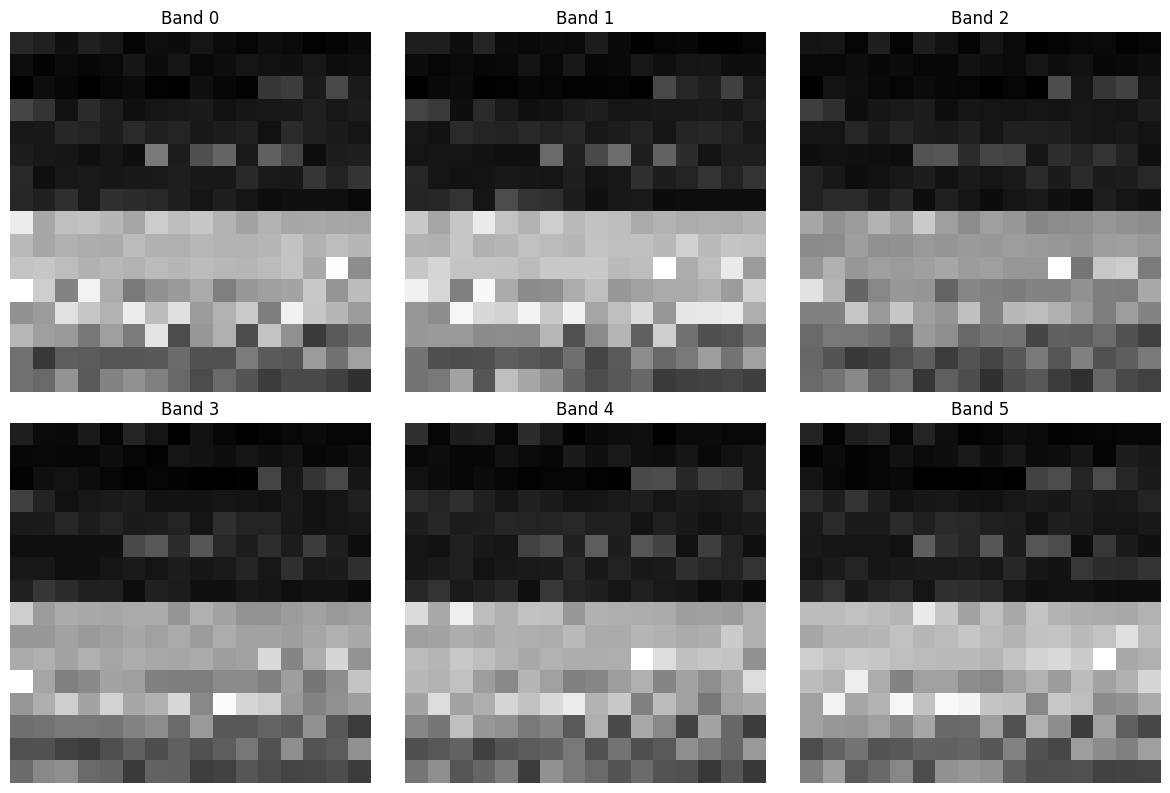

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for b in range(6):
    ax = axs[b // 3, b % 3]
    ax.imshow(sample_patch[:, :, b], cmap='gray')
    ax.set_title(f"Band {b}")
    ax.axis('off')
plt.tight_layout()
plt.show()


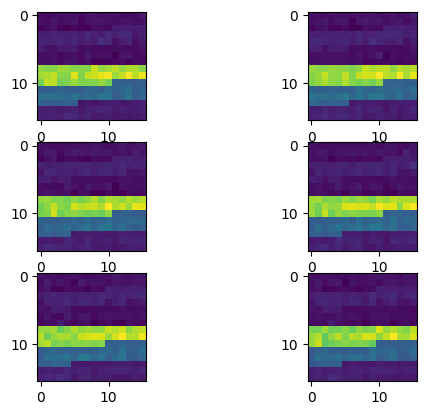

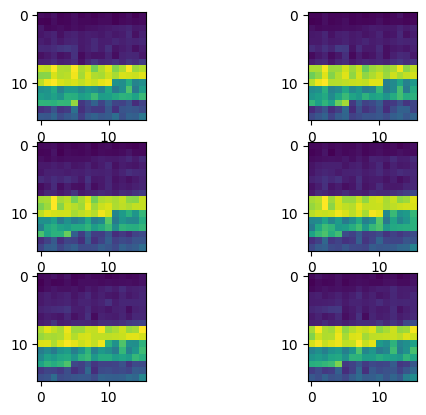

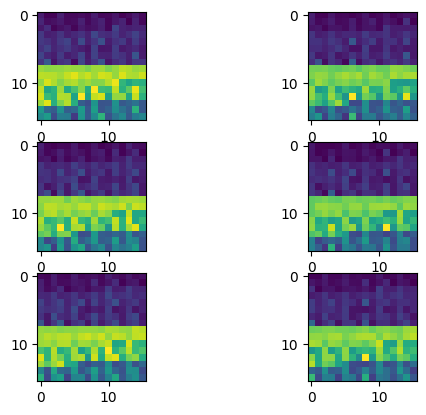

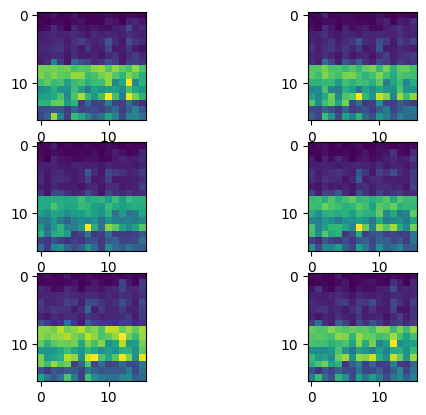

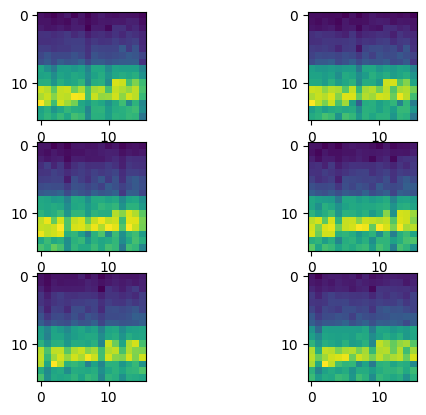

In [ ]:
for j in range(5):
    for i in range(6):
        plt.subplot(3, 2, i+1)
        plt.imshow(X_test[j][:, :,i], interpolation='nearest')
    plt.show()

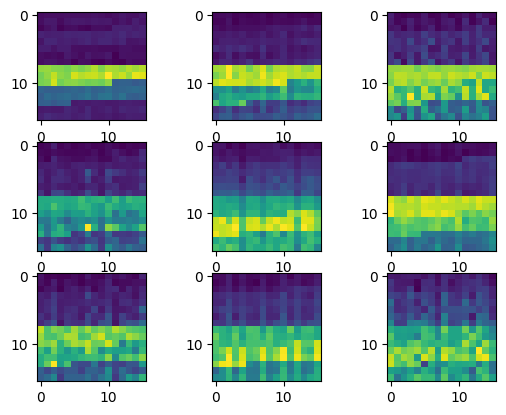

In [ ]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i][:, :,2], interpolation='nearest')
plt.show()

In [ ]:
pixel = X[42][5][10]
print("Pixel values at (5, 10) in image 42:")
print(f"Blue: {pixel[0]}\nGreen: {pixel[1]}\nRed: {pixel[2]}")
print(f"NIR: {pixel[3]}\nSWIR1: {pixel[4]}\nSWIR2: {pixel[5]}")

Pixel values at (5, 10) in image 42:
Blue: 1591
Green: 1630
Red: 1601
NIR: 1608
SWIR1: 775
SWIR2: 790


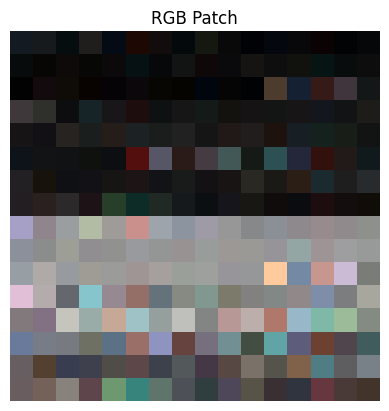

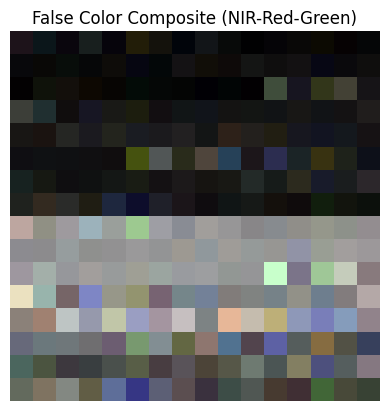

In [ ]:
patch = X[0]

#print("RGB Composite:")
rgb = np.stack([patch[:, :, 2], patch[:, :, 1], patch[:, :, 0]], axis=-1)
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

plt.imshow(rgb)
plt.title("RGB Patch")
plt.axis('off')
plt.show()

#print("False Color (NIR-Red-Green, commonly used for vegetation)")
fc = np.stack([patch[:, :, 3], patch[:, :, 2], patch[:, :, 1]], axis=-1)
fc = (fc - fc.min()) / (fc.max() - fc.min())

plt.imshow(fc)
plt.title("False Color Composite (NIR-Red-Green)")
plt.axis('off')
plt.show()


### Understanding the Distribution of the Dataset

Band 1: min=-9999, max=20000, mean=1563.44, std=1020.33
Band 2: min=-9999, max=20000, mean=1563.44, std=1020.31
Band 3: min=-9999, max=20000, mean=1561.15, std=1018.95
Band 4: min=-9999, max=20000, mean=1561.16, std=1018.94
Band 5: min=-9999, max=20000, mean=1562.17, std=1018.87
Band 6: min=-9999, max=20000, mean=1562.17, std=1018.86


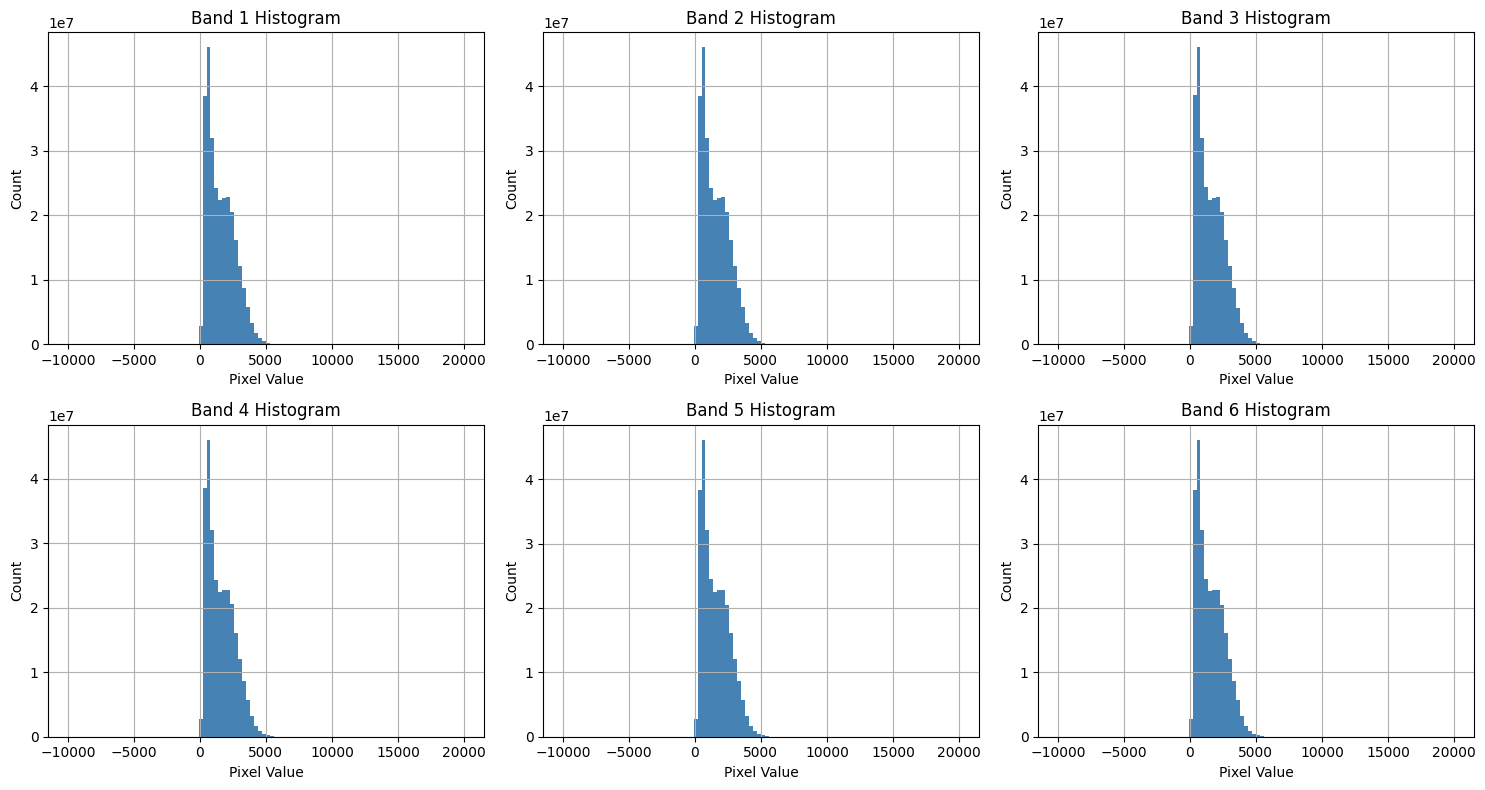

In [ ]:
for band in range(6):
    band_values = X[:, :, :, band].flatten()
    print(f"Band {band+1}: min={band_values.min()}, max={band_values.max()}, "
          f"mean={band_values.mean():.2f}, std={band_values.std():.2f}")
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
for band in range(6):
    plt.subplot(2, 3, band + 1)
    plt.hist(X[:, :, :, band].flatten(), bins=100, color='steelblue')
    plt.title(f"Band {band+1} Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Count")
    plt.grid(True)
plt.tight_layout()
plt.show()


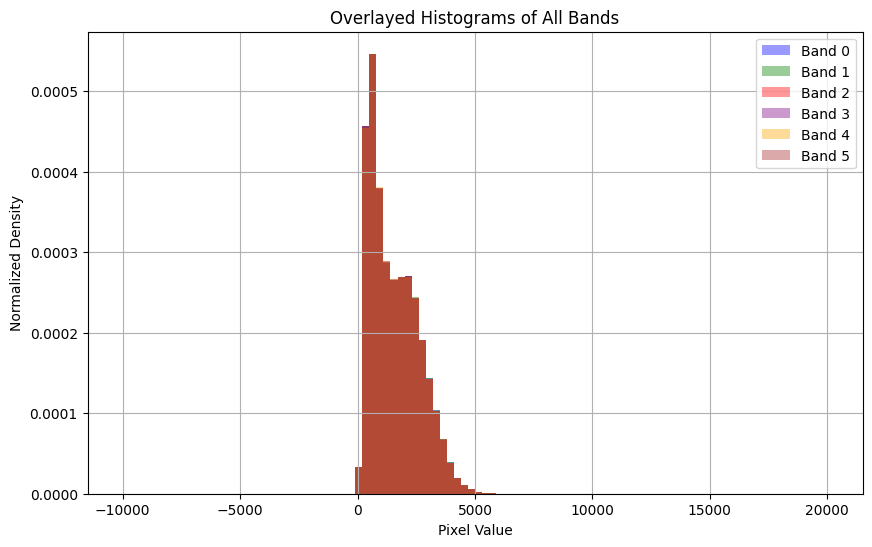

In [ ]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
for band in range(6):
    values = X[:, :, :, band].flatten()
    plt.hist(values, bins=100, alpha=0.4, label=f'Band {band}', color=colors[band], density=True)

plt.title("Overlayed Histograms of All Bands")
plt.xlabel("Pixel Value")
plt.ylabel("Normalized Density")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
for band in range(6):
    band_values = X[:, :, :, band].flatten()
    print(f"Band {band+1}: min={band_values.min()}, max={band_values.max()}, "
          f"mean={band_values.mean():.2f}, std={band_values.std():.2f}")


Band 1: min=-9999, max=20000, mean=1563.44, std=1020.33
Band 2: min=-9999, max=20000, mean=1563.44, std=1020.31
Band 3: min=-9999, max=20000, mean=1561.15, std=1018.95
Band 4: min=-9999, max=20000, mean=1561.16, std=1018.94
Band 5: min=-9999, max=20000, mean=1562.17, std=1018.87
Band 6: min=-9999, max=20000, mean=1562.17, std=1018.86


### Outlier Detection

Z-Score method

Rule: If |Z-score|>3 => data is an outlier

In [ ]:
import numpy as np
from scipy.stats import zscore

outlier_counts = []
for band in range(6):
    values = X[:, :, :, band].flatten()
    z = zscore(values)
    count = np.sum(np.abs(z) > 3)
    outlier_counts.append(count)

for i, count in enumerate(outlier_counts):
    print(f"Band {i}: {count} outliers (Z-score > 3)")


Band 0: 1017904 outliers (Z-score > 3)
Band 1: 1017532 outliers (Z-score > 3)
Band 2: 1023306 outliers (Z-score > 3)
Band 3: 1023024 outliers (Z-score > 3)
Band 4: 1035877 outliers (Z-score > 3)
Band 5: 1035793 outliers (Z-score > 3)


InterQuartile Range method

Rule: Values not belonging to [Q1 - 1.5×IQR, Q3 + 1.5×IQR] are outliers

In [ ]:
outlier_counts = []
for band in range(6):
    values = X[:, :, :, band].flatten()
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    count = np.sum((values < lower) | (values > upper))
    outlier_counts.append(count)

for i, count in enumerate(outlier_counts):
    print(f"Band {i}: {count} outliers (IQR method)")


Band 0: 795747 outliers (IQR method)
Band 1: 795595 outliers (IQR method)
Band 2: 797706 outliers (IQR method)
Band 3: 797294 outliers (IQR method)
Band 4: 821120 outliers (IQR method)
Band 5: 821164 outliers (IQR method)


Since data appears to be positively-skewed, we use IQR Method

In [ ]:
import numpy as np

outlier_counts = []
total_values = X.shape[0] * X.shape[1] * X.shape[2]

for band in range(6):
    values = X[:, :, :, band].flatten()
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = (values < lower_bound) | (values > upper_bound)
    count = np.sum(outliers)
    outlier_counts.append((count, (count / total_values) * 100))

# Print results
for i, (count, percent) in enumerate(outlier_counts):
    print(f"Band {i}: {count} outliers ({percent:.4f}%) using IQR method")


Band 0: 795747 outliers (0.2826%) using IQR method
Band 1: 795595 outliers (0.2825%) using IQR method
Band 2: 797706 outliers (0.2833%) using IQR method
Band 3: 797294 outliers (0.2831%) using IQR method
Band 4: 821120 outliers (0.2916%) using IQR method
Band 5: 821164 outliers (0.2916%) using IQR method


In [ ]:
def mad_z_score(values):
    median = np.median(values)
    mad = np.median(np.abs(values - median))
    return 0.6745 * (values - median) / (mad + 1e-8)

outlier_counts = []
for band in range(6):
    values = X[:, :, :, band].flatten()
    mad_z = mad_z_score(values)
    count = np.sum(np.abs(mad_z) > 3.5)
    outlier_counts.append((count, (count / total_values) * 100))

# Print results
for i, (count, percent) in enumerate(outlier_counts):
    print(f"Band {i}: {count} outliers ({percent:.4f}%) using MAD method")


Band 0: 129054 outliers (0.0458%) using MAD method
Band 1: 129083 outliers (0.0458%) using MAD method
Band 2: 131870 outliers (0.0468%) using MAD method
Band 3: 131968 outliers (0.0469%) using MAD method
Band 4: 135671 outliers (0.0482%) using MAD method
Band 5: 135583 outliers (0.0481%) using MAD method


In [ ]:
# Wrong code (DO NOT USE)

print("Original shape:", X.shape)

def detect_outliers_iqr(sample, threshold_ratio=0.01):
    """
    Detect if a 16x16x6 sample contains too many IQR-based outliers.
    """
    flattened = sample.flatten()  # Shape: (16*16*6 = 1536,)
    Q1 = np.percentile(flattened, 25)
    Q3 = np.percentile(flattened, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_count = np.sum((flattened < lower_bound) | (flattened > upper_bound))
    return outlier_count > (threshold_ratio * len(flattened))  # e.g., > 1% outliers

# Apply to all images
mask = np.array([not detect_outliers_iqr(sample) for sample in X])

# Filter dataset
X_clean = X[mask]
y_clean = y[mask]

print("Filtered shape (no outlier images):", X_clean.shape)
print(f"Removed {len(X) - len(X_clean)} images due to outliers.")

Original shape: (1100000, 16, 16, 6)
Filtered shape (no outlier images): (995265, 16, 16, 6)
Removed 104735 images due to outliers.


### IQR Outlier

In [ ]:
import numpy as np
import h5py

# Reshape for per-band analysis: (1100000 * 16 * 16, 6)
pixels_per_band = X.reshape(-1, 6)


Q1 = np.percentile(pixels_per_band, 25, axis=0)
Q3 = np.percentile(pixels_per_band, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Function to check how many outlier pixels per image per band
outlier_counts = np.zeros((X.shape[0], 6), dtype=int)

for band in range(6):
    band_data = X[..., band]
    is_outlier = (band_data < lower_bound[band]) | (band_data > upper_bound[band])
    outlier_counts[:, band] = np.sum(is_outlier.reshape(X.shape[0], -1), axis=1)

# Count number of images with more than 10 outlier pixels in each band
band_outlier_images = (outlier_counts > 10).sum(axis=0)

images_with_outliers = np.any(outlier_counts > 10, axis=1).sum()

print("Images with >10 outlier pixels in any band:", images_with_outliers)
for band in range(6):
    print(f"Band {band}: {band_outlier_images[band]} images have >10 outlier pixels")


Images with >10 outlier pixels in any band: 20453
Band 0: 18430 images have >10 outlier pixels
Band 1: 18387 images have >10 outlier pixels
Band 2: 18533 images have >10 outlier pixels
Band 3: 18522 images have >10 outlier pixels
Band 4: 18948 images have >10 outlier pixels
Band 5: 18910 images have >10 outlier pixels


### Robust Scaling (throwing errors)

In [ ]:
# Step 1: Log transform to reduce skewness
X_log = np.log1p(X)  # Applies log(1 + x) safely, preserves zeros

# Step 2: Robust normalization (using Median and IQR)
# Flatten spatial dims to compute stats per band
X_flat = X_log.reshape(-1, 6)

medians = np.median(X_flat, axis=0)
q1 = np.percentile(X_flat, 25, axis=0)
q3 = np.percentile(X_flat, 75, axis=0)
iqr = q3 - q1 + 1e-6  # Add epsilon to avoid division by zero

# Normalize: (x - median) / IQR
X_robust = (X_log - medians) / iqr

C:\Users\DELL\AppData\Local\Temp\ipykernel_13192\2110302374.py:2: RuntimeWarning: divide by zero encountered in log1p
  X_log = np.log1p(X)  # Applies log(1 + x) safely, preserves zeros
C:\Users\DELL\AppData\Local\Temp\ipykernel_13192\2110302374.py:2: RuntimeWarning: invalid value encountered in log1p
  X_log = np.log1p(X)  # Applies log(1 + x) safely, preserves zeros


MemoryError: Unable to allocate 6.29 GiB for an array with shape (1100000, 16, 16, 6) and data type float32

In [ ]:
# Save processed data
with h5py.File("train_data_processed.h5", "w") as hdf:
    hdf.create_dataset("images", data=X_robust)
    hdf.create_dataset("labels", data=y)

In [ ]:
import numpy as np
from sklearn.preprocessing import RobustScaler

def handle_invalid_values(data):
    return np.nan_to_num(data, nan=0.0, posinf=1e30, neginf=-1e30)

# Reshape the data: (N, C, H, W) → (N, H, W, C) → (N, H*W*C)
def reshape_for_scaling(images):
    # From (N, C, H, W) to (N, H, W, C)
    images = np.moveaxis(images, 1, -1)
    # Flatten spatial + channel dimensions: (N, H*W*C)
    return images.reshape(images.shape[0], -1)

# Handle invalid values
X_clean = handle_invalid_values(X)
X_test_clean = handle_invalid_values(X_test)

# Reshape for scaling
X_reshaped = reshape_for_scaling(X_clean)
X_test_reshaped = reshape_for_scaling(X_test_clean)

# Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Output: X_scaled (train), y, X_test_scaled
print("Preprocessed train shape:", X_scaled.shape)
print("Preprocessed test shape:", X_test_scaled.shape)


MemoryError: Unable to allocate 12.6 GiB for an array with shape (1100000, 1536) and data type float64

### Batchwise Robust normz (errors)

In [ ]:
import h5py
import numpy as np
from tqdm import tqdm

input_file = "train_data.h5"
output_file = "train_data_log_robust_normalized.h5"
batch_size = 10000

with h5py.File(input_file, "r") as f:
    X = f["images"]
    n_samples, h, w, c = X.shape

    # Accumulate per-band flattened data for IQR estimation
    sampled_data = []

    for i in tqdm(range(0, n_samples, batch_size), desc="Sampling for stats"):
        batch = X[i:i+batch_size]
        batch_log = np.log1p(batch)
        flat = batch_log.reshape(-1, c)

        # Sample a small subset to reduce memory (e.g., 5% of batch)
        sampled = flat[np.random.choice(flat.shape[0], size=int(flat.shape[0]*0.05), replace=False)]
        sampled_data.append(sampled)

    sampled_all = np.vstack(sampled_data)
    medians = np.median(sampled_all, axis=0)
    q1 = np.percentile(sampled_all, 25, axis=0)
    q3 = np.percentile(sampled_all, 75, axis=0)
    iqr = q3 - q1 + 1e-6

    del sampled_data, sampled_all  # Free memory

# Now normalize batch-wise and save to new HDF5
with h5py.File(input_file, "r") as fin, h5py.File(output_file, "w") as fout:
    X = fin["images"]
    dset = fout.create_dataset("images", shape=X.shape, dtype="float32")

    for i in tqdm(range(0, n_samples, batch_size), desc="Writing normalized data"):
        batch = X[i:i+batch_size]
        batch_log = np.log1p(batch)
        batch_norm = (batch_log - medians) / iqr
        dset[i:i+batch_size] = batch_norm.astype("float32")

print("✅ Log + robust normalization complete. Output saved to:", output_file)


Sampling for stats:   0%|          | 0/110 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_13192\2066332932.py:18: RuntimeWarning: divide by zero encountered in log1p
  batch_log = np.log1p(batch)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13192\2066332932.py:18: RuntimeWarning: invalid value encountered in log1p
  batch_log = np.log1p(batch)
Writing normalized data:   0%|          | 0/110 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_13192\2066332932.py:40: RuntimeWarning: divide by zero encountered in log1p
  batch_log = np.log1p(batch)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13192\2066332932.py:40: RuntimeWarning: invalid value encountered in log1p
  batch_log = np.log1p(batch)
Writing normalized data: 100%|██████████| 110/110 [04:52<00:00,  2.66s/it]

✅ Log + robust normalization complete. Output saved to: train_data_log_robust_normalized.h5


d:\Users\Desktop\satellite-itu\venv\Lib\site-packages\matplotlib\axes\_axes.py:7101: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
d:\Users\Desktop\satellite-itu\venv\Lib\site-packages\matplotlib\axes\_axes.py:7102: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

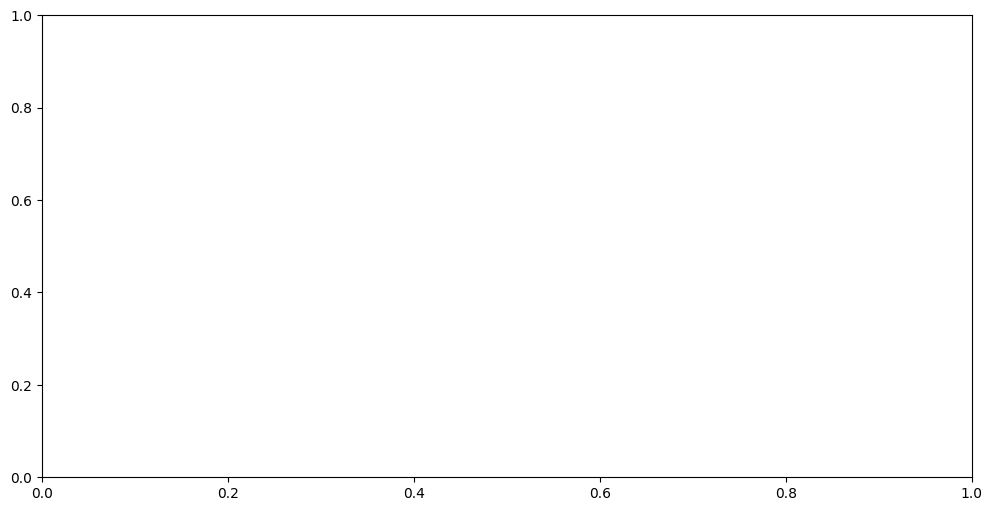

In [ ]:
import h5py
import matplotlib.pyplot as plt

# Load normalized data
with h5py.File("train_data_log_robust_normalized.h5", "r") as f:
    X = f["images"][:]

# Flatten and plot
flattened = X.reshape(-1, X.shape[-1])
plt.figure(figsize=(12, 6))
for i in range(flattened.shape[1]):
    plt.hist(flattened[:, i], bins=100, alpha=0.6, label=f'Band {i+1}')
plt.title("Histograms of Robust Normalized Features")
plt.xlabel("Normalized Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


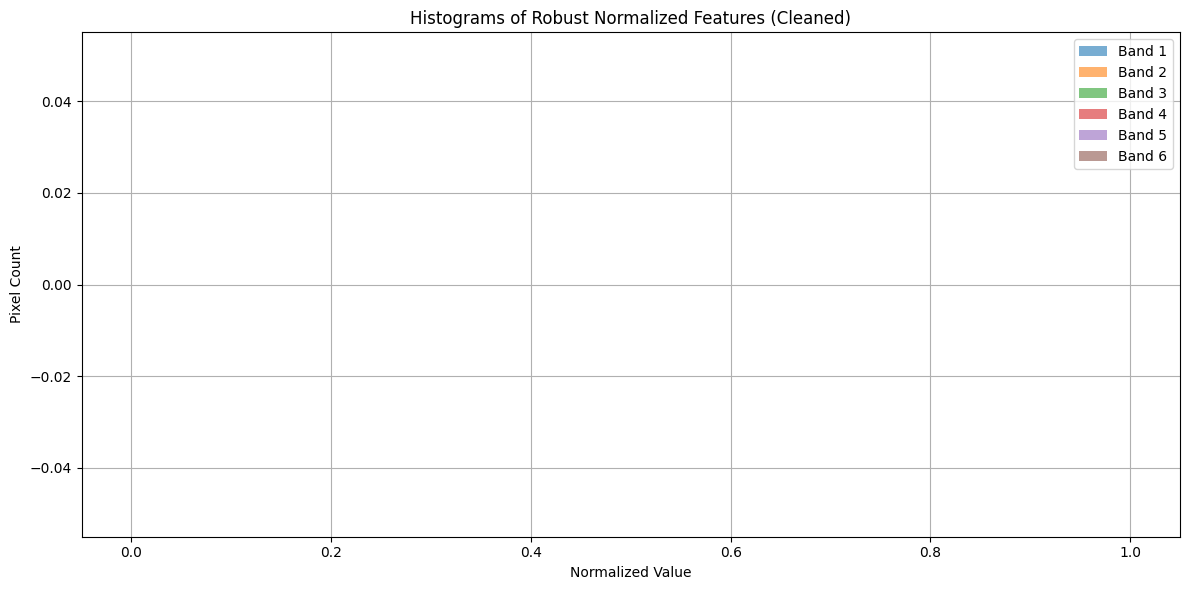

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load normalized data
with h5py.File("train_data_log_robust_normalized.h5", "r") as f:
    X = f["images"][:10000]  # Load small chunk to avoid memory issues

# Flatten spatial dimensions
flattened = X.reshape(-1, X.shape[-1])  # Shape: (10000*16*16, 6)

# Remove any rows with NaN or Inf
mask = np.all(np.isfinite(flattened), axis=1)
flattened = flattened[mask]

# Plot histograms
plt.figure(figsize=(12, 6))
for i in range(flattened.shape[1]):
    plt.hist(flattened[:, i], bins=100, alpha=0.6, label=f'Band {i+1}')

plt.title("Histograms of Robust Normalized Features (Cleaned)")
plt.xlabel("Normalized Value")
plt.ylabel("Pixel Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Balance data

In [ ]:
# Step 1: Count the number of 1's in y
num_ones = np.sum(y == 1)

# Step 2: Get indices of 0's and 1's in y
ones_indices = np.where(y == 1)[0]
zeros_indices = np.where(y == 0)[0]

# Step 3: Randomly sample the same number of 0's as there are 1's
balanced_zero_indices = np.random.choice(zeros_indices, num_ones, replace=False)

# Step 4: Combine indices of 0's and 1's
balanced_indices = np.concatenate([ones_indices, balanced_zero_indices])

# Step 5: Create balanced X and y
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

# Display the number of 0's and 1's in the balanced y
print(f"Number of 1's in balanced y: {np.sum(y_balanced == 1)}")
print(f"Number of 0's in balanced y: {np.sum(y_balanced == 0)}")

Number of 1's in balanced y: 100000
Number of 0's in balanced y: 100000


In [ ]:
from sklearn.utils import shuffle
# Shuffle both X_balanced and y_balanced together
X_train, y_train = shuffle(X_balanced, y_balanced, random_state=1)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(200000, 16, 16, 6)
(120000, 16, 16, 6)


### Baseline models

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define and train the baseline model
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_flat, y_train)

y_pred_train = rf.predict(X_train_flat)
y_pred_test = rf.predict(X_test_flat)


# Evaluate the model
train_accuracy_rf = accuracy_score(y_train, y_pred_train)

## 0.9999 accuracy: OVERFITTING
print(f'Baseline RF model training accuracy: {train_accuracy_rf:.4f}')


Baseline RF model training accuracy: 0.9999


#### Multi layer perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Scale the data to [0,1]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Define and train the MLP model
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=20, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_train_mlp = mlp_model.predict(X_train_scaled)
y_pred_test_mlp = mlp_model.predict(X_test_scaled)


# Evaluate the model
train_accuracy_mlp = accuracy_score(y_train, y_pred_train_mlp)


## ~0.60 accuracy: UNDERFITTING
print(f'Baseline MLP model training accuracy: {train_accuracy_mlp:.4f}')




d:\Users\Desktop\satellite-itu\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Baseline MLP model training accuracy: 0.6044


#### XGBoost

In [ ]:
# Flatten the image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Step 2: Standardize the data (optional but helps with gradient-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled=scaler.fit_transform(X_test_flat)

#pca = PCA(n_components=100)  # Reduce to 100 principal components (you can adjust this number)
#X_train_pca = pca.fit_transform(X_train_flat)
#X_test_pca = pca.fit_transform(X_test_flat)

X_train_s,X_val,y_train_s,y_val=train_test_split(X_scaled,y_train,train_size=0.7,random_state=42)


In [ ]:
%pip install xgboost --prefer-binary

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/b8/84/9d0618b1bc0d9dd421b9a44a472535e353c27703ae42ab8db86b2ea33a25/xgboost-3.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/149.9 MB 1.7 MB/s eta 0:01:31
   ---------------------------------------- 0.1/149.9 MB 1.7 MB/s eta 0:01:31
   ---------------------------------------- 0.2/149.9 MB 1.5 MB/s eta 0:01:38
   ---------------------------------------- 0.2/149.9 MB 1.6 MB/s eta 0:01:34
   ---------------------------------------- 0.3/149.9 MB 1.5 MB/s eta 0:01:39
   ---------------------------------------- 0.4/14


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report
import xgboost as xgb
Best_hyperparameters= {'lambda': 0.7823070736187078, 'alpha': 2.9436065951113097e-07, 'colsample_bytree': 0.562150929489243, 'subsample': 0.8811221939106899, 'learning_rate': 0.15834633713229113, 'n_estimators': 794, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.17635703760632648}
model = xgb.XGBClassifier(**Best_hyperparameters, use_label_encoder=False)
model.fit(X_train_s, y_train_s, eval_set=[(X_val, y_val)], verbose=False)

# Step 6: Make predictions
y_pred = model.predict_proba(X_val)[:, 1]  # Probability of the positive class

# Step 7: Calculate the AUC
auc = roc_auc_score(y_val, y_pred)
auc

d:\Users\Desktop\satellite-itu\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:45:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


0.8653870332988776

In [ ]:
def trainer(model,X,y,cv,X_test):
    '''
    The function trains and cross-validate the models
    '''
    X=pd.DataFrame(X)
    y=pd.DataFrame(y)
    cv_reports = []
    roc_aucs = []
    predictions=[]
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y), 1):

        X_fold_train = X.iloc[train_idx]
        X_fold_valid = X.iloc[valid_idx]
        y_fold_train = y.iloc[train_idx]
        y_fold_valid = y.iloc[valid_idx]



        model.fit(X_fold_train, y_fold_train)

        # Predict on the validation fold
        y_fold_pred = model.predict(X_fold_valid)
        y_fold_pred_prob = model.predict_proba(X_fold_valid)[:, 1]
        predict= model.predict_proba(X_test)[:, 1]
        predictions.append(predict)

        # Calculate and store the classification report for this fold
        report = classification_report(y_fold_valid, y_fold_pred, output_dict=True)
        cv_reports.append(report)

        # Calculate and store the ROC AUC score for this fold
        roc_auc = roc_auc_score(y_fold_valid, y_fold_pred_prob)
        roc_aucs.append(roc_auc)

        # Print classification report for the current fold
        print(f"Fold {fold} Classification Report:")
        print(classification_report(y_fold_valid, y_fold_pred))
        print(f"Fold {fold} ROC AUC: {roc_auc:.4f}")
        print("-" * 50)

    # Summary of CV results
    print(f"Mean ROC AUC across folds: {np.mean(roc_aucs):.4f}")
    return predictions

In [ ]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
predictions=trainer(model,X_scaled,y_train,cv,X_test_scaled)
y_pred_test=np.mean(predictions,axis=0)
prediction = pd.DataFrame(y_pred_test)
prediction.head()

d:\Users\Desktop\satellite-itu\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:17:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     20000
           1       0.79      0.79      0.79     20000

    accuracy                           0.79     40000
   macro avg       0.79      0.79      0.79     40000
weighted avg       0.79      0.79      0.79     40000

Fold 1 ROC AUC: 0.8710
--------------------------------------------------


d:\Users\Desktop\satellite-itu\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:33:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     20000
           1       0.78      0.78      0.78     20000

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000

Fold 2 ROC AUC: 0.8677
--------------------------------------------------


d:\Users\Desktop\satellite-itu\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:49:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78     20000
           1       0.78      0.79      0.78     20000

    accuracy                           0.78     40000
   macro avg       0.78      0.78      0.78     40000
weighted avg       0.78      0.78      0.78     40000

Fold 3 ROC AUC: 0.8670
--------------------------------------------------


d:\Users\Desktop\satellite-itu\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:06:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


KeyboardInterrupt: 